C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17216\2533621449.py:40: RuntimeWarning: invalid value encountered in scalar divide
  avg_speed = d / t_total


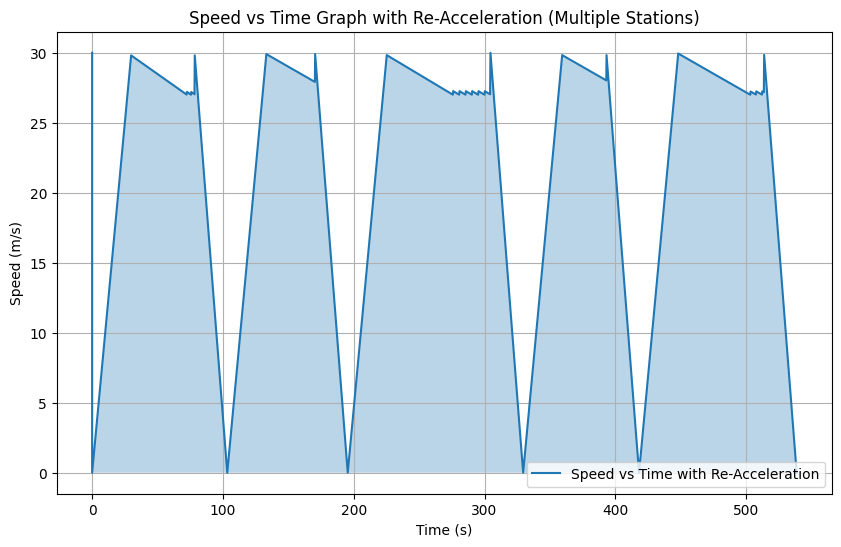

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv

# Function to calculate train resistance at a given velocity (normal + additional resistances)
def train_resistance(v, A, B, C, curve_resistance=0, gradient_resistance=0):
    return A + B * v + C * v**2 + curve_resistance + gradient_resistance

# Function to calculate curve resistance based on the curve radius
def calculate_curve_resistance(curve_radius, mass_train):
    if curve_radius == 0:
        return 0
    return mass_train / curve_radius

# Function to calculate gradient resistance based on the gradient ratio
def calculate_gradient_resistance(gradient_ratio, mass_train):
    if gradient_ratio == 0:
        return 0
    return mass_train / gradient_ratio

# Function to calculate coasting deceleration at a given speed
def coasting_deceleration(v, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    F_r = train_resistance(v, A, B, C, curve_resistance, gradient_resistance)
    return -F_r / mass_train  # Deceleration is negative since it opposes motion

# Function to calculate average speed with reacceleration phase for a segment
def calculate_average_speed_with_reacceleration(d, a, b, m, A, B, C, mass_train, curve_resistance=0, gradient_resistance=0):
    # Time to accelerate and brake
    t_accel = m / a
    t_brake = m / b

    # Distance covered during acceleration and braking phases
    d_accel = 0.5 * a * t_accel**2
    d_brake = 0.5 * b * t_brake**2

    # Check if the train reaches max speed
    if d_accel + d_brake > d:
        # The train never reaches max speed
        t_total = np.sqrt(2 * d / (a + b))
        avg_speed = d / t_total
        return avg_speed, t_total, t_total / 2, 0, t_total / 2, 0  # t_coast = 0, reacceleration = 0
    else:
        # Distance to cover during coasting
        d_coast = d - (d_accel + d_brake)
        v = m  # starting speed for coasting
        dt = 0.1  # time step
        t_coast = 0

        # Threshold for speed to trigger re-acceleration
        speed_threshold = 0.9 * m
        reacceleration_times = 0

        while v > 0 and d_coast > 0:
            decel = coasting_deceleration(v, A, B, C, mass_train, curve_resistance, gradient_resistance)
            v = max(0, v + decel * dt)  # Update velocity based on deceleration
            d_coast -= v * dt  # Update distance covered during this time step
            t_coast += dt

            # Check if speed falls below 90% of max speed and trigger re-acceleration
            if v < speed_threshold and d_coast > 0:
                while v < m and d_coast > 0:
                    v += a * dt  # Accelerate back to max speed
                    d_coast -= v * dt
                    t_coast += dt
                reacceleration_times += 1

        # Total time
        t_total = t_accel + t_coast + t_brake
        avg_speed = d / t_total
        return avg_speed, t_total, t_accel, t_coast, t_brake, reacceleration_times

# Function to parse the stations CSV file
def parse_stations(filename):
    stations = []
    distances = []

    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        previous_chainage = 0
        
        for row in reader:
            chainage = float(row[0])  # Chainage in meters
            station_name = row[1]
            stations.append(station_name)
            
            if len(distances) > 0:
                distances.append(chainage - previous_chainage)  # Distance in meters
            else:
                distances.append(chainage)  # First station distance is from zero

            previous_chainage = chainage

    return distances, stations

# Function to parse the curves CSV file
def parse_curves(filename):
    curves = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        
        for row in reader:
            curve_start = float(row[1])
            curve_end = float(row[2])
            curve_radius = float(row[3])
            curves.append((curve_start, curve_end, curve_radius))

    return curves

# Function to parse the gradients CSV file
def parse_gradients(filename):
    gradients = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip the header row
        
        for row in reader:
            gradient_start = float(row[1])
            gradient_end = float(row[2])
            gradient_ratio = float(row[3])
            gradients.append((gradient_start, gradient_end, gradient_ratio))

    return gradients

# Function to calculate cumulative resistances from curves and gradients in a segment
def calculate_cumulative_resistance(total_distance, curves, gradients, mass_train):
    curve_resistance = 0
    gradient_resistance = 0
    
    for curve_start, curve_end, curve_radius in curves:
        if curve_start <= total_distance <= curve_end:
            curve_resistance += calculate_curve_resistance(curve_radius, mass_train)
    
    for gradient_start, gradient_end, gradient_ratio in gradients:
        if gradient_start <= total_distance <= gradient_end:
            gradient_resistance += calculate_gradient_resistance(gradient_ratio, mass_train)

    return curve_resistance, gradient_resistance

# Function to plot speed vs time for multiple stations
def plot_speed_vs_time_with_reacceleration(distances, stations, a, b, m, A, B, C, mass_train, curves, gradients):
    total_time = 0
    time_points = []
    speed_points = []

    total_distance = 0

    for idx, d in enumerate(distances):
        # Calculate cumulative resistance from curves and gradients
        curve_resistance, gradient_resistance = calculate_cumulative_resistance(total_distance, curves, gradients, mass_train)

        avg_speed, segment_time, t_accel, t_coast, t_brake, reaccel_times = calculate_average_speed_with_reacceleration(
            d, a, b, m, A, B, C, mass_train, curve_resistance, gradient_resistance
        )
        
        time_points_segment = np.linspace(total_time, total_time + segment_time, 500)
        speed_points_segment = np.zeros_like(time_points_segment)

        for i in range(len(time_points_segment)):
            t = time_points_segment[i] - total_time
            if t < t_accel:
                speed_points_segment[i] = a * t
            elif t < t_accel + t_coast:
                v_prev = speed_points_segment[i-1] if i > 0 else m
                decel = coasting_deceleration(v_prev, A, B, C, mass_train, curve_resistance, gradient_resistance)
                speed_points_segment[i] = max(0, v_prev + decel * (time_points_segment[i] - time_points_segment[i-1]))
                if speed_points_segment[i] < 0.9 * m:
                    # Re-accelerate when speed drops below 90% of max speed
                    speed_points_segment[i] += a * (time_points_segment[i] - time_points_segment[i-1])
            else:
                time_since_brake = t - t_accel - t_coast
                speed_points_segment[i] = max(0, m - b * time_since_brake)

        # Append time and speed points
        time_points.extend(time_points_segment)
        speed_points.extend(speed_points_segment)
        total_time += segment_time
        total_distance += d

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, speed_points, label='Speed vs Time with Re-Acceleration')
    plt.fill_between(time_points, 0, speed_points, alpha=0.3)
    plt.title("Speed vs Time Graph with Re-Acceleration (Multiple Stations)")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage of the functions
distances, stations = parse_stations("stations.csv")
curves = parse_curves("curves.csv")
gradients = parse_gradients("gradients.csv")

# Inputs: acceleration (m/s²), braking (m/s²), max speed (m/s), coefficients (A, B, C), mass of train (kg)
a = 1  # acceleration in m/s²
b = 1.2  # braking in m/s²
m = 30  # max speed in m/s
A, B, C = 10, 0.01, 0.0005  # resistance coefficients
mass_train = 200  # mass of train in tons (200 tons)

plot_speed_vs_time_with_reacceleration(distances, stations, a, b, m, A, B, C, mass_train, curves, gradients)
